In [163]:
from FLAI import data
from FLAI import causal_graph
import pandas as pd


In [164]:
df = pd.read_pickle('adult.pickle')
df.head(5)

,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,label
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [165]:
df.columns

Index(['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30',
       'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60',
       'Age (decade)=>=70', 'Education Years=6', 'Education Years=7',
       'Education Years=8', 'Education Years=9', 'Education Years=10',
       'Education Years=11', 'Education Years=12', 'Education Years=<6',
       'Education Years=>12', 'label'],
      dtype='object')

In [166]:
df['age'] = df.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df['education'] = df.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)

In [167]:
flai_dataset = data.Data(df[['sex', 'race', 'age','education' ,'label']], transform=True)
#flai_dataset = data.Data(df, transform=True)

In [168]:
flai_dataset.data.head()

,sex,race,age,education,label
0,1.0,0.0,2.0,4.0,0.0
1,1.0,0.0,1.0,4.0,0.0
2,1.0,1.0,2.0,8.0,1.0
3,1.0,1.0,1.0,8.0,0.0
4,1.0,1.0,2.0,8.0,0.0


In [169]:
from pgmpy.estimators import HillClimbSearch

import pandas as pd
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square
est = PC(flai_dataset.data)
skel, seperating_sets = est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = pdag.to_dag()
print("DAG edges:        ", model.edges())
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore



mmhc = MmhcEstimator(flai_dataset.data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(flai_dataset.data)
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(flai_dataset.data))
print("Part 2) Model:    ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('sex', 'race'), ('sex', 'age'), ('sex', 'education'), ('sex', 'label'), ('race', 'age'), ('race', 'education'), ('age', 'education'), ('age', 'label'), ('education', 'label')]
PDAG edges:        [('label', 'sex'), ('label', 'age'), ('label', 'education'), ('sex', 'age'), ('sex', 'race'), ('sex', 'label'), ('sex', 'education'), ('race', 'sex'), ('race', 'age'), ('race', 'education'), ('age', 'label'), ('age', 'education'), ('age', 'race'), ('age', 'sex'), ('education', 'sex'), ('education', 'label'), ('education', 'age'), ('education', 'race')]
DAG edges:         [('sex', 'label'), ('race', 'sex'), ('race', 'education'), ('race', 'age'), ('age', 'label'), ('age', 'sex'), ('age', 'education'), ('education', 'label'), ('education', 'sex')]
Part 1) Skeleton:  [('sex', 'education'), ('sex', 'label'), ('sex', 'race'), ('sex', 'age'), ('race', 'age'), ('race', 'education'), ('age', 'label'), ('age', 'education'), ('education', 'label')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Part 2) Model:     [('sex', 'label'), ('sex', 'race'), ('age', 'race'), ('education', 'label'), ('education', 'age'), ('education', 'sex'), ('label', 'age')]


In [170]:
flai_graph = causal_graph.CausalGraph(flai_dataset)

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


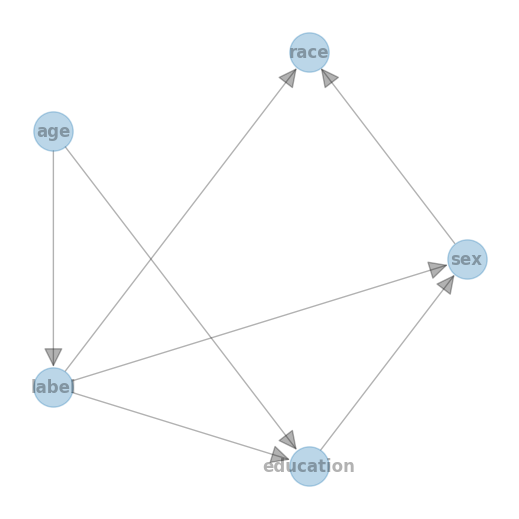

In [171]:
flai_graph.plot(directed = True)

In [172]:
list(flai_graph.graph['model_edges'])

[('sex', 'race'),
 ('age', 'label'),
 ('age', 'education'),
 ('education', 'sex'),
 ('label', 'education'),
 ('label', 'sex'),
 ('label', 'race')]

In [173]:
#flai_graph.graph['model_edges'] = [('sex', 'label'), ('sex', 'race'), ('age', 'race'), ('education', 'label'), ('education', 'age'), ('sex', 'education'), ('label', 'age')]
flai_graph.graph['model_edges'] = [('sex', 'label'),  ('education', 'label'), ('age', 'education'), ('sex', 'education'), ('age', 'label'), ('race','label')]

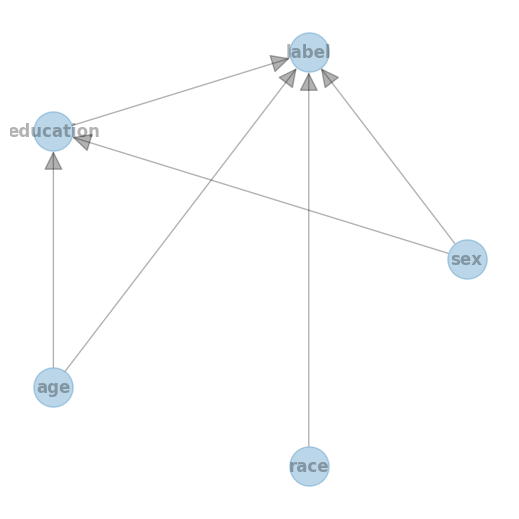

In [174]:
flai_graph.plot(directed = True)

In [175]:
#flai_graph.learn_cpd(methodtype = 'maximumlikelihood')
flai_graph.calculate_cpd()

In [78]:
flai_graph_o = flai_graph

In [79]:
CPDs = flai_graph.get_CPDs()

In [120]:
CPDs['education'][['sex','age']].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [156]:
[{'when' :{zip[0] : zip[1] for zip in zip([c for c in CPDs['label'].columns if c not in ['label','p']],group)},'then' : {int(v[0]) : v[1]for v in CPDs['label'].groupby([c for c in CPDs['label'].columns if c not in ['label','p']]).get_group(group)[['label','p']].values.tolist()}} for group in CPDs['label'].groupby([c for c in CPDs['label'].columns if c not in ['label','p']]).groups.keys()]

[{'when': {'sex': 0, 'education': 0, 'age': 0, 'race': 0},
  'then': {0: 1.0, 1: 0.0}},
 {'when': {'sex': 0, 'education': 0, 'age': 0, 'race': 1},
  'then': {0: 1.0, 1: 0.0}},
 {'when': {'sex': 0, 'education': 0, 'age': 1, 'race': 0},
  'then': {0: 1.0, 1: 0.0}},
 {'when': {'sex': 0, 'education': 0, 'age': 1, 'race': 1},
  'then': {0: 1.0, 1: 0.0}},
 {'when': {'sex': 0, 'education': 0, 'age': 2, 'race': 0},
  'then': {0: 1.0, 1: 0.0}},
 {'when': {'sex': 0, 'education': 0, 'age': 2, 'race': 1},
  'then': {0: 0.9846153846153847, 1: 0.015384615384615385}},
 {'when': {'sex': 0, 'education': 0, 'age': 3, 'race': 0},
  'then': {0: 0.9230769230769231, 1: 0.07692307692307693}},
 {'when': {'sex': 0, 'education': 0, 'age': 3, 'race': 1},
  'then': {0: 0.9629629629629629, 1: 0.037037037037037035}},
 {'when': {'sex': 0, 'education': 0, 'age': 4, 'race': 0},
  'then': {0: 1.0, 1: 0.0}},
 {'when': {'sex': 0, 'education': 0, 'age': 4, 'race': 1},
  'then': {0: 0.9852941176470589, 1: 0.014705882352941

In [143]:
{int(v[0]) : v[1]for v in CPDs['education'].groupby(['sex','age']).get_group((2,0))[['education','p']].values.tolist()}

{0: 0.022857142857142857,
 1: 0.01804511278195489,
 2: 0.024962406015037596,
 3: 0.006616541353383459,
 4: 0.2754887218045113,
 5: 0.34466165413533834,
 6: 0.042105263157894736,
 7: 0.043308270676691726,
 8: 0.2219548872180451}

In [101]:
{int(v[0]) : v[1]for v in CPDs['education'].values.tolist()}

{0: 6.0, 1: 6.0, 2: 6.0, 3: 6.0, 4: 6.0, 5: 6.0, 6: 6.0, 7: 6.0, 8: 6.0}

In [97]:
CPDs.keys()

dict_keys(['sex', 'race', 'age', 'education', 'label'])

In [157]:
{k : {'id' : k,'states' : CPDs[k][k].unique().tolist(), 'parents' : [c for c in CPDs[k].columns if c not in [k,'p']], 'cpt' : {int(v[0]) : v[1]for v in CPDs[k].values.tolist()}} for k in list(CPDs.keys())[4:5]}

{'label': {'id': 'label',
  'states': [0, 1],
  'parents': ['sex', 'education', 'age', 'race'],
  'cpt': {0: 1.0, 1: 1.0}}}

In [178]:
import numpy as np
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['label'], evidence={})
print(q.scope())
print(np.round(q.values*100,2))
q

['label']
[76.76 23.24]


<DiscreteFactor representing phi(label:2) at 0x7f1a49feb610>

In [154]:
import numpy as np
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
{n : list(np.round(infer.query(variables=[n], evidence={}).values*100,2)) for n in flai_graph.graph['model'].nodes()}


{'sex': [33.12, 66.88],
 'label': [76.76, 23.24],
 'education': [5.38, 2.91, 3.76, 1.34, 32.3, 22.17, 4.3, 3.31, 24.52],
 'age': [5.23, 24.54, 26.35, 22.21, 13.42, 6.19, 2.06],
 'race': [14.62, 85.38]}

In [16]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['label'], evidence={
                                'sex':1})
print(q.scope())
print(q.values)
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['label'], evidence={
                                'sex':0})
print(q.scope())
print(q.values)

['label']
[0.71343413 0.28656587]
['label']
[0.87690552 0.12309448]


In [17]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['label'], evidence={
                                'race':1})
print(q.scope())
print(q.values)
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['label'], evidence={
                                'race':0})
print(q.scope())
print(q.values)

['label']
[0.75981921 0.24018079]
['label']
[0.81283315 0.18716685]


In [22]:
import bnlearn as bn
data = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = bn.predict(flai_graph.graph, data, variables = ['label'])
flai_dataset.data['Predicted'] = out.label

[bnlearn]> Remaining columns for inference: 4


100%|██████████| 240/240 [00:00<00:00, 529.61it/s]


In [23]:
#### male = 1 female = 0
flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


{'model': {'ACC': 0.8052590014332095,
  'TPR': 0.3913203835751168,
  'FPR': 0.06551525618883132,
  'FNR': 0.6086796164248832,
  'PPP': 0.14302845944602066},
 'sex': {'privileged': {'ACC': 0.7636331831897494,
   'TPR': 0.4625781136462723,
   'FPR': 0.10678093331665207,
   'FNR': 0.5374218863537277,
   'PPP': 0.21384527922333493},
  'unprivileged': {'ACC': 0.8893305069775658,
   'TPR': 0.0,
   'FPR': 0.0,
   'FNR': 1.0,
   'PPP': 0.0},
  'fair_metrics': {'Equal_Opportunity_Difference': -0.4625781136462723,
   'Disparate Impact': 0.0,
   'Statistical parity Difference': -0.21384527922333493}},
 'race': {'privileged': {'ACC': 0.7958274810729334,
   'TPR': 0.4071205326810708,
   'FPR': 0.07314950531330157,
   'FNR': 0.5928794673189292,
   'PPP': 0.15734301668322428},
  'unprivileged': {'ACC': 0.860344137655062,
   'TPR': 0.24129032258064517,
   'FPR': 0.02604783329386692,
   'FNR': 0.7587096774193548,
   'PPP': 0.05942376950780312},
  'fair_metrics': {'Equal_Opportunity_Difference': -0.1658

In [47]:
len(flai_dataset.data[(flai_dataset.data['Predicted'] == 1) & (flai_dataset.data['sex'] == 0)])  / len(flai_dataset.data[(flai_dataset.data['Predicted'] == 1) & (flai_dataset.data['sex'] == 1)]) 

0.0

In [38]:
flai_graph.graph['model_edges'] =   flai_graph.mitigate_edge_relation(sensible_feature = ['sex'])

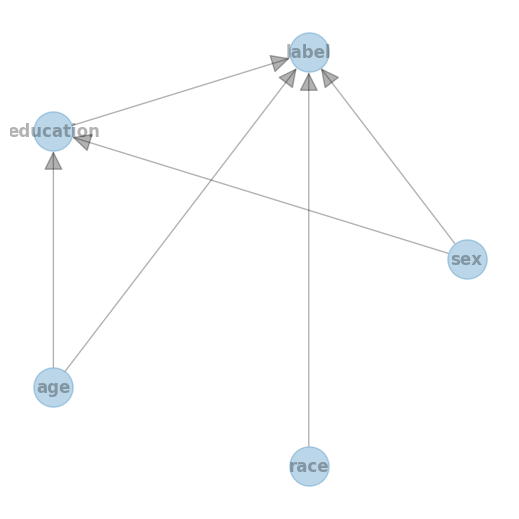

In [39]:
flai_graph.plot(directed =True)

In [40]:
flai_graph.mitigate_calculation_cpd(sensible_feature = ['sex','race'])


In [27]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['label'], evidence={
                                'sex':0})
print(q.scope())
print(q.values)
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['label'], evidence={
                                'sex':1})
print(q.scope())
print(q.values)

['label']
[0.76208722 0.23791278]
['label']
[0.76208722 0.23791278]


In [56]:
CPDs = flai_graph.get_CPDs()
CPDs['education'].education.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [59]:
print('none ', np.round(infer.query(variables=['label'], evidence={}).values*100,2))
for v in CPDs['sex'].sex.unique().tolist():
    print('sex ', v,  ' ', np.round(infer.query(variables=['label'], evidence={'sex' : v}).values*100,2))
    print('sex ', v,  ' ', np.round(infer2.query(variables=['label'], evidence={'sex' : v}).values*100,2))
for v in CPDs['race'].race.unique().tolist():
    print('race ', v,  ' ', np.round(infer.query(variables=['label'], evidence={'race' : v}).values*100,2))
    print('race ', v,  ' ', np.round(infer2.query(variables=['label'], evidence={'race' : v}).values*100,2))
for v in CPDs['age'].age.unique().tolist():
    print('age ', v,  ' ', np.round(infer.query(variables=['label'], evidence={'age' : v}).values*100,2))
    print('age ', v,  ' ', np.round(infer2.query(variables=['label'], evidence={'age' : v}).values*100,2))
for v in CPDs['education'].education.unique().tolist():
    print('education ', v,  ' ', np.round(infer.query(variables=['label'], evidence={'education' : v}).values*100,2))
    print('education ', v,  ' ', np.round(infer2.query(variables=['label'], evidence={'education' : v}).values*100,2))


none  [76.76 23.24]
sex  0   [87.69 12.31]
sex  0   [76.21 23.79]
sex  1   [71.34 28.66]
sex  1   [76.21 23.79]
race  0   [81.28 18.72]
race  0   [76.21 23.79]
race  1   [75.98 24.02]
race  1   [76.21 23.79]
age  0   [99.81  0.19]
age  0   [99.83  0.17]
age  1   [93.68  6.32]
age  1   [93.95  6.05]
age  2   [73.53 26.47]
age  2   [72.99 27.01]
age  3   [63.97 36.03]
age  3   [63.03 36.97]
age  4   [64.79 35.21]
age  4   [63.11 36.89]
age  5   [74.07 25.93]
age  5   [73.5 26.5]
age  6   [81.78 18.22]
age  6   [81.68 18.32]
education  0   [94.67  5.33]
education  0   [94.56  5.44]
education  1   [93.55  6.45]
education  1   [93.27  6.73]
education  2   [95.53  4.47]
education  2   [95.46  4.54]
education  3   [93.9  6.1]
education  3   [93.61  6.39]
education  4   [84.79 15.21]
education  4   [84.3 15.7]
education  5   [81.4 18.6]
education  5   [81.14 18.86]
education  6   [75.21 24.79]
education  6   [74.76 25.24]
education  7   [74.24 25.76]
education  7   [73.69 26.31]
education  8  

In [63]:
for v in CPDs['education'].education.unique().tolist():
    print('education ', v,  ' ', np.round(infer.query(variables=['label'], evidence={'education' : v,'race':0}).values*100,2))
    print('education ', v,  ' ', np.round(infer2.query(variables=['label'], evidence={'education' : v,'race':0}).values*100,2))


education  0   [95.54  4.46]
education  0   [94.56  5.44]
education  1   [96.8  3.2]
education  1   [93.27  6.73]
education  2   [96.6  3.4]
education  2   [95.46  4.54]
education  3   [92.82  7.18]
education  3   [93.61  6.39]
education  4   [89.98 10.02]
education  4   [84.3 15.7]
education  5   [83.71 16.29]
education  5   [81.14 18.86]
education  6   [80.04 19.96]
education  6   [74.76 25.24]
education  7   [80.65 19.35]
education  7   [73.69 26.31]
education  8   [59.99 40.01]
education  8   [52.02 47.98]


In [64]:
for v in CPDs['education'].education.unique().tolist():
    print('education ', v,  ' ', np.round(infer.query(variables=['label'], evidence={'education' : v,'race':1}).values*100,2))
    print('education ', v,  ' ', np.round(infer2.query(variables=['label'], evidence={'education' : v,'race':1}).values*100,2))

education  0   [94.52  5.48]
education  0   [94.56  5.44]
education  1   [92.99  7.01]
education  1   [93.27  6.73]
education  2   [95.34  4.66]
education  2   [95.46  4.54]
education  3   [94.09  5.91]
education  3   [93.61  6.39]
education  4   [83.9 16.1]
education  4   [84.3 15.7]
education  5   [81.01 18.99]
education  5   [81.14 18.86]
education  6   [74.39 25.61]
education  6   [74.76 25.24]
education  7   [73.15 26.85]
education  7   [73.69 26.31]
education  8   [51.62 48.38]
education  8   [52.02 47.98]


In [58]:
import numpy as np
from pgmpy.inference import VariableElimination
infer2 = VariableElimination(flai_graph.graph['model'])


In [ ]:
q = infer2.query(variables=['label'], evidence={'sex' : 1})
print(q.scope())
print(np.round(q.values*100,2))

In [25]:
import bnlearn as bn
data = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = bn.predict(flai_graph.graph, data, variables = ['label'])
flai_dataset.data['Predicted'] = out.label

[bnlearn]> Remaining columns for inference: 4


100%|██████████| 240/240 [00:00<00:00, 619.47it/s]


In [26]:
#### male = 1 female = 0
flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                               columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


{'model': {'ACC': 0.788791716634005,
  'TPR': 0.46250307351856407,
  'FPR': 0.1093456150450969,
  'FNR': 0.537496926481436,
  'PPP': 0.19336628740238088},
 'sex': {'privileged': {'ACC': 0.7617090129881489,
   'TPR': 0.4605435256503415,
   'FPR': 0.10865757537845615,
   'FNR': 0.5394564743496585,
   'PPP': 0.2145449774784624},
  'unprivileged': {'ACC': 0.8434905493729024,
   'TPR': 0.47326416600159615,
   'FPR': 0.1104379779521303,
   'FNR': 0.5267358339984038,
   'PPP': 0.15059176823882706},
  'fair_metrics': {'Equal_Opportunity_Difference': 0.012720640351254642,
   'Disparate Impact': 0.7019123449484832,
   'Statistical parity Difference': -0.06395320923963535}},
 'race': {'privileged': {'ACC': 0.7816792847110411,
   'TPR': 0.4621551841282783,
   'FPR': 0.11061744228655185,
   'FNR': 0.5378448158717217,
   'PPP': 0.19923949162413074},
  'unprivileged': {'ACC': 0.8303321328531412,
   'TPR': 0.46580645161290324,
   'FPR': 0.10277054226852948,
   'FNR': 0.5341935483870968,
   'PPP': 0.15

In [67]:
len(flai_dataset.data[(flai_dataset.data['Predicted'] == 1) & (flai_dataset.data['sex'] == 1)]) / len(flai_dataset.data[(flai_dataset.data['sex'] == 1)])

0.2145449774784624

In [66]:
len(flai_dataset.data[(flai_dataset.data['sex'] == 1)])

22867

In [16]:
flai_dataset.data[['sex', 'race', 'age','education'  ,'label']].to_excel('original_adult.xls')


In [27]:
mitigate_data = flai_graph.generate_dataset(n_samples = 10000, methodtype = 'bayes')

In [30]:
mitigate_data.data.to_pickle('mitigated_adult.pickle')

In [28]:
import bnlearn as bn
data = mitigate_data.data[list(flai_graph.graph['model'].nodes())]
out = bn.predict(flai_graph.graph, data, variables = ['label'])
mitigate_data.data['Predicted'] = out.label

[bnlearn]> Remaining columns for inference: 4


100%|██████████| 231/231 [00:00<00:00, 1126.08it/s]


In [29]:
#### male = 1 female = 0
mitigate_data.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                               columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


{'model': {'ACC': 0.7881,
  'TPR': 0.46321070234113715,
  'FPR': 0.10975289169295478,
  'FNR': 0.5367892976588629,
  'PPP': 0.1943},
 'sex': {'privileged': {'ACC': 0.7873357228195937,
   'TPR': 0.4646128226477935,
   'FPR': 0.11122742737503272,
   'FNR': 0.5353871773522065,
   'PPP': 0.19573874950219036},
  'unprivileged': {'ACC': 0.78887103254319,
   'TPR': 0.4617968094038623,
   'FPR': 0.10826511750726169,
   'FNR': 0.5382031905961377,
   'PPP': 0.19284853354760947},
  'fair_metrics': {'Equal_Opportunity_Difference': -0.0028160132439312147,
   'Disparate Impact': 0.9852343188973497,
   'Statistical parity Difference': -0.002890215954580888}},
 'race': {'privileged': {'ACC': 0.7827314908210611,
   'TPR': 0.46296296296296297,
   'FPR': 0.11036339165545088,
   'FNR': 0.5370370370370371,
   'PPP': 0.19870889650998588},
  'unprivileged': {'ACC': 0.7933769581598255,
   'TPR': 0.46347826086956523,
   'FPR': 0.1091703056768559,
   'FNR': 0.5365217391304348,
   'PPP': 0.1899662899068015},
  '

In [30]:
len(mitigate_data.data[(mitigate_data.data['Predicted'] == 1) & (mitigate_data.data['sex'] == 0)]) / len(mitigate_data.data[(mitigate_data.data['Predicted'] == 1) & (mitigate_data.data['sex'] == 1)])

1.038338658146965

In [37]:
len(mitigate_data.data[mitigate_data.data['sex'] == 1])

6684

In [26]:
CPDs = flai_graph.get_CPDs()

In [28]:
CPDs['age']

,age,p
0,0,0.796968
1,1,0.203032


In [29]:
CPDs['race']

,race,p
0,0,0.602599
1,1,0.397401


In [30]:
CPDs['sex']

,sex,p
0,0,0.804548
1,1,0.195452


In [32]:
CPDs['priors']

,priors,race,sex,p
0,0,0,0,0.684894
1,0,0,1,0.684894
2,0,1,0,0.684894
3,0,1,1,0.684894
4,1,0,0,0.315106
5,1,0,1,0.315106
6,1,1,0,0.315106
7,1,1,1,0.315106
